In [19]:
# Downloaded libraries
from matplotlib import pyplot as plt
import numpy as np
import pynwb

# Own libraries
import main


In [24]:
from scipy.ndimage import filters
def figsmooth(A,sig):
    '''apply Gaussian smoothing to matrix A containing nans with kernel sig
    without propogating nans'''

    # find zero indices to weight the smoothing matrix
    zero_inds = np.where(A == 0)

    # inversely weight zero indices
    One = np.ones(A.shape)
    One[zero_inds] = .001
    A = filters.gaussian_filter(A,sig)
    One = filters.gaussian_filter(One,sig)
    return A/One

In [110]:
fname1 = "sub-F1_ses-20190407T210000_behavior+ophys_small.nwb"
fname2 = "sub-F1_ses-20190416T210000_behavior+ophys_small.nwb"
fname3 = "sub-R1_ses-20190211T210000_behavior+ophys_small.nwb"
fname4 = "sub-R1_ses-20190223T210000_behavior+ophys_small.nwb"
directory = "data\TestPlitt"

F1early = main.getSessionHandle(fname1, directory)
F1late = main.getSessionHandle(fname2, directory)
R1early = main.getSessionHandle(fname3, directory)
R1late = main.getSessionHandle(fname4, directory)

In [120]:
data = main.dataExtraction(R1early.read())

# nFrames = data["nFrames"]
nNeurons = data["nNeurons"]
deconvTraces = data["deconvTraces"]
# tstartData = data["tstartData"]
# nTrials = data["nTrials"]
startIndices = data["startIndices"]
baseMorph = data["baseMorph"]
# totalMorph = data["totalMorph"]
position = data["position"]

In [121]:
dbs, pbs = main.trialize(deconvTraces, position, startIndices)
df, occp = main.positionalBin(dbs, pbs)

In [122]:
SIMatrix = np.zeros((nNeurons, 5))
baseMorphList = baseMorph[startIndices]

for i in range(nNeurons):
    SIMatrix[i,:] = main.getSpatialInformation(df[:,:,i], occp, baseMorphList)
    # print(SIMatrix[i,:])

# placeCellInds = main.extractPlaceCells(SIMatrix, 97)

In [123]:
threshold = np.percentile(SIMatrix, 95)

placeCellInds = {}
for i, key in enumerate(main.baseMorphValues):
    placeCellInds[key] = np.where(SIMatrix[:,i] > threshold)[0]

In [124]:
# extracts the sub-dataframes for the place cells for each basemorph value (all trials)
df_placeCells = {key:df[:,:,placeCellInds[key]] for key in main.baseMorphValues}

# gets the indices of the trials at each base morph value
baseIndices = {i:np.where(baseMorphList == i)[0] for i in main.baseMorphValues}

avgActivity = {key:{} for key in main.baseMorphValues}
for cells in main.baseMorphValues:
    for trials in main.baseMorphValues:
        bInds = baseIndices[trials]
        num = np.sum(df_placeCells[cells][bInds], axis = 0)
        den = np.sum(occp[bInds], axis = 0).reshape(-1,1)
        avgActivity[cells][trials] = num / den


In [125]:
avgActMat = np.empty((5,), dtype=object)
for i, row in enumerate(main.baseMorphValues):
    for j, col in enumerate(main.baseMorphValues):
        if j == 0:
            avgActMat[i] = avgActivity[row][col]
        else:
            avgActMat[i] = np.vstack((avgActMat[i], avgActivity[row][col]))

norms = [np.max(mat, axis=0) for mat in avgActMat]

In [128]:
# for i in avgActMat:
#     print(np.shape(i))
print(SIMatrix[:10])

[[1.46429200e+01 6.19550398e+01 8.09274565e+01 7.86339292e+01
  7.77476092e+01]
 [2.94935658e+01 2.99194601e+01 3.54639035e+01 3.49670705e+01
  3.41524766e+01]
 [2.45448914e+00 5.34126844e+00 2.11267377e+01 3.21278964e+01
  4.61178189e+01]
 [6.72215144e-01 1.21420612e+01 2.52791969e+01 3.31786371e+01
  2.08074628e+01]
 [2.53922552e+01 2.37467116e+00 9.33232700e+00 6.28485679e-01
  6.09765877e-02]
 [1.03768337e+01 2.31044898e+01 2.01765108e+01 9.84339506e+00
  1.11640316e+01]
 [1.69965236e+00 2.35722238e+01 4.42062284e+01 2.32825630e+01
  1.68648097e+01]
 [1.85894202e+01 8.67924973e+00 1.26805847e+01 1.32317084e+01
  1.00690038e+01]
 [6.45094362e+00 2.62190750e+01 3.33163617e+01 1.42309197e+01
  2.09344227e+01]
 [3.49279090e+01 6.58015954e+00 2.94963505e+00 1.76931376e+01
  1.35263672e+00]]


C:\Users\tarek\AppData\Local\Temp\ipykernel_25876\2643713151.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  A = filters.gaussian_filter(A,sig)
C:\Users\tarek\AppData\Local\Temp\ipykernel_25876\2643713151.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  One = filters.gaussian_filter(One,sig)


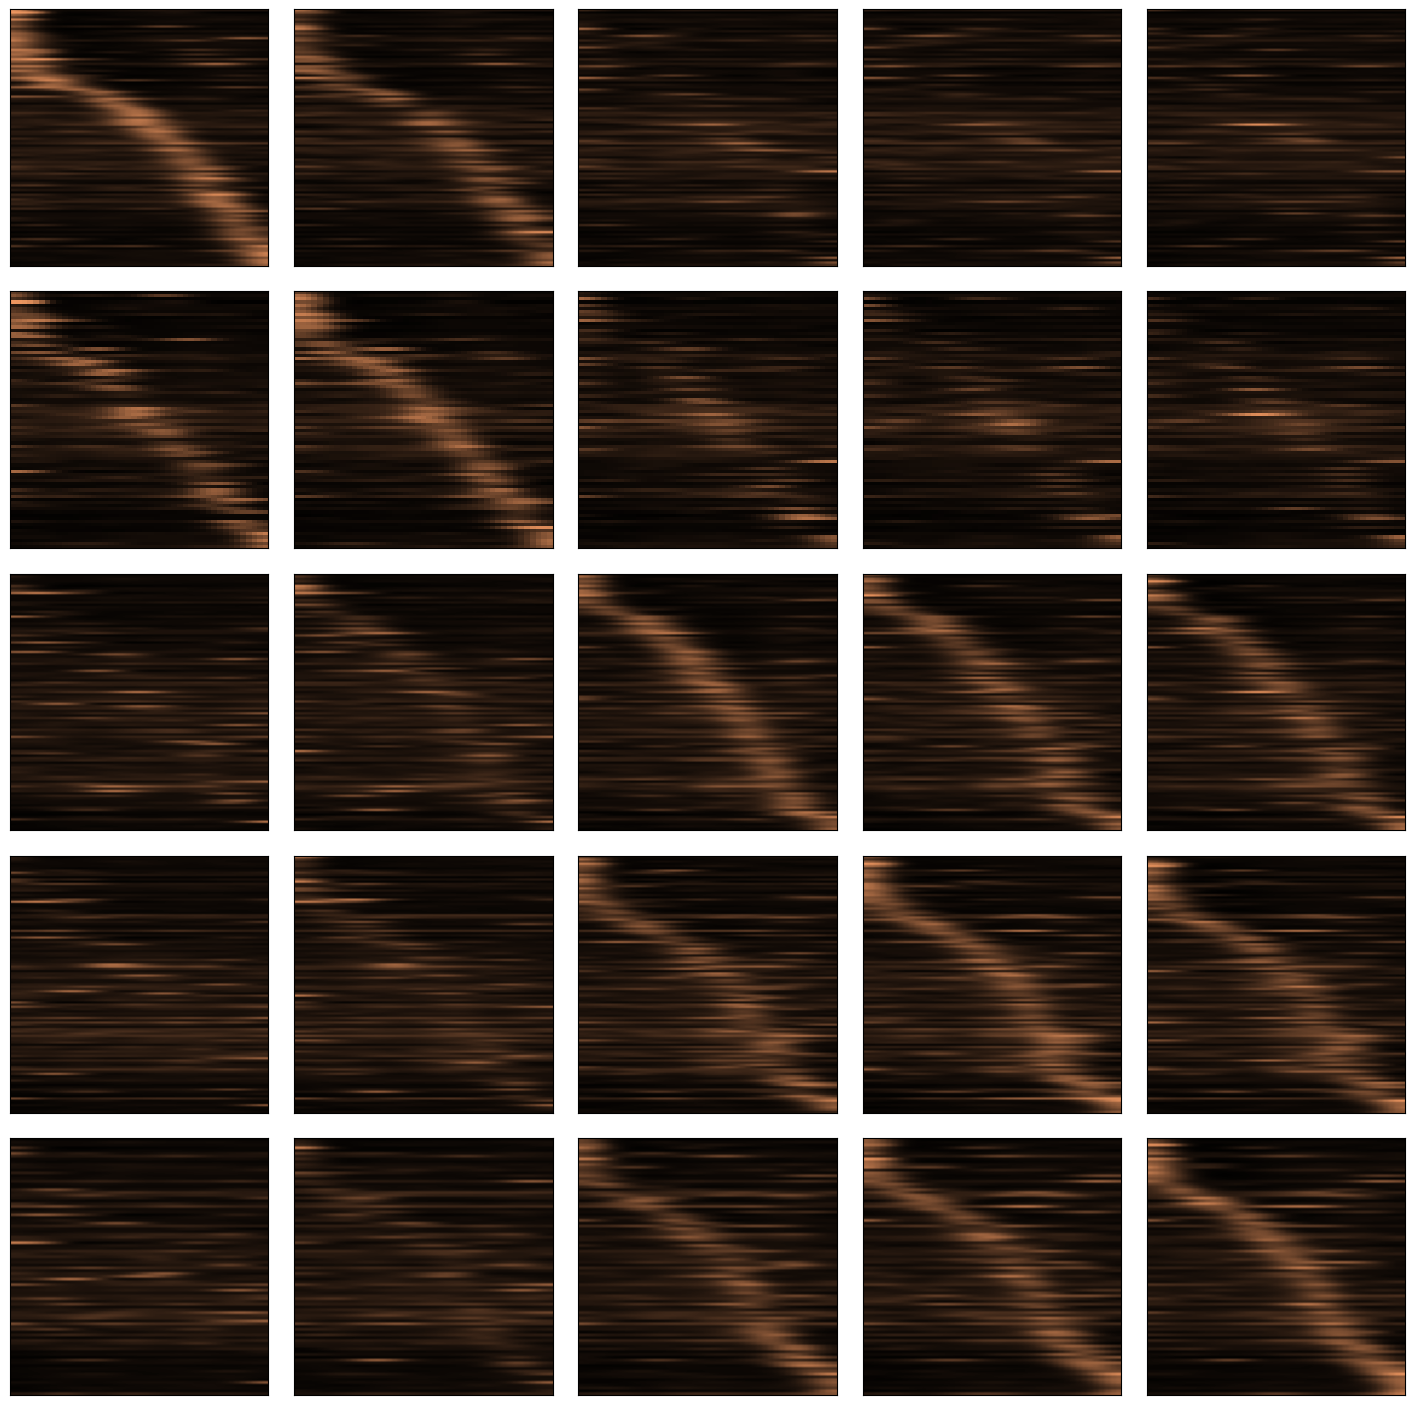

In [117]:
fig, ax = plt.subplots(5,5, figsize=(18,18))

for row, cells in enumerate(main.baseMorphValues):
    for col, trials in enumerate(main.baseMorphValues):
        cellsToPlot = np.transpose(avgActivity[cells][trials][:,np.argsort(np.argmax(avgActivity[cells][cells],axis=0))])
#         newNorms = np.max(cellsToPlot, axis = 1).reshape(-1,1)
#         newNorms = np.max(np.transpose(avgActivity[cells][cells][:,np.argsort(np.argmax(avgActivity[cells][cells],axis=0))]), axis = 1).reshape(-1,1)
        newNorms = norms[row][np.argsort(np.argmax(avgActivity[cells][cells],axis=0))]
        ax[row, col].imshow(figsmooth(cellsToPlot/newNorms.reshape(-1,1),[0,3]),cmap='copper', vmin = 0, vmax=0.9, aspect="auto")
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)        
plt.show()